In [111]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB 1.3 MB/s eta 0:00:01
   ----- --------------------------------- 41.0/294.9 kB 388.9 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/294.9 kB 930.9 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/294.9 kB 952.6 kB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import keras 
from PIL import Image
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda, BatchNormalization,AveragePooling2D 
from keras.models import Model

In [3]:
import cv2

df = pd.read_csv('train_chestXRAY.csv')

In [4]:
LABELS = {
    'PNEUMONIA' : 0,
    'NORMAL':1
}

In [5]:
train_ds_path = r'C:\Users\adina\Desktop\תקיית_עבודות\chest_xray\train'
validaion_ds_path = r"C:\Users\adina\Desktop\תקיית_עבודות\chest_xray\val"
test_ds_path = r"C:\Users\adina\Desktop\תקיית_עבודות\chest_xray\test"

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np
from scipy.ndimage import convolve
import random
import cv2


class ImageProcessor:
    
    @staticmethod
    def get_array_from_choices(img_array):
        options = [1, 2, 3]        
        choice = random.sample(options, 2)
        if choice == [1, 2]:
            img_array = ImageProcessor.increase_contrast(img_array)
            img_array = ImageProcessor.sharpened_image(img_array)
        elif choice == [1, 3]:
            img_array = ImageProcessor.increase_contrast(img_array)
        else:
            img_array = ImageProcessor.sharpened_image(img_array)
        return img_array
    
    @staticmethod
    def crop_image(img):
        w, h = img.size
        size = min(w, h)
        x = (w - size) // 2
        y = (h - size) // 2
        img = img.crop((x, y, x + size, y + size))
        return img_to_array(img)
        
    @staticmethod
    def increase_contrast(img_array, factor=1.5):
        # Apply contrast stretching
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255.0
    
        # Increase the contrast by multiplying pixel values with a factor
        img_array = img_array * factor
    
        # Clip pixel values to be in the valid range [0, 255]
        img_array = np.clip(img_array, 0, 255)
    
        return img_array
    
    @staticmethod
    def sharpened_image(img_array):
        kernel = np.array([[[0, -1, 0],
                            [-1, 5, -1],
                            [0, -1, 0]]], dtype=np.float32)
        sharpened_img = convolve(img_array, kernel)
        return sharpened_img

    @staticmethod
    def adaptive_thresholding(img_array):
        img_array = np.uint8(img_array)
        channels = cv2.split(img_array)
        
        max_output_value = 255
        neighborhood_size = 99
        subtract_from_mean = 10
        image_binarized = [cv2.adaptiveThreshold(channel,
                                max_output_value,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY,
                                neighborhood_size,
                                subtract_from_mean) for channel in channels]
        image_binarized = cv2.merge(image_binarized)
        return image_binarized
    
    @staticmethod
    def preprocess_image(img_path, target_size=None):
        samples = []
        # regular image
        img = load_img(img_path, target_size=target_size)
        original_img_arr = img_to_array(img)
        samples.append(original_img_arr)
        # After croping image 
        img_arr_after_crop = ImageProcessor.crop_image(img)
        samples.append(img_arr_after_crop)
        # After sharpening image 
        img_array_after_sharp = ImageProcessor.sharpened_image(original_img_arr)
        samples.append(img_array_after_sharp)
        # After increasing contrast image 
        img_arr_after_increase_contrast = ImageProcessor.increase_contrast(original_img_arr)
        samples.append(img_arr_after_increase_contrast)
        # After croping and another filters 
        samples.append(ImageProcessor.increase_contrast(img_arr_after_crop))
        samples.append(ImageProcessor.sharpened_image(img_arr_after_crop))

        # adaptive thresholding images 
        samples.append(ImageProcessor.adaptive_thresholding(img_arr_after_crop))
        samples.append(ImageProcessor.adaptive_thresholding(original_img_arr))
        samples.append(ImageProcessor.adaptive_thresholding(img_arr_after_increase_contrast))
        samples.append(ImageProcessor.adaptive_thresholding(img_array_after_sharp))
        samples.append(ImageProcessor.adaptive_thresholding(img_array_after_sharp))
        return samples

In [7]:
import os

def generate_df_from_url(ds_path, csv_filename, to_csv=True):
    images = []
    X = []
    y = []
    for main_dir in os.listdir(ds_path):
        main_dir_path = os.path.join(ds_path, main_dir)
        if os.path.isdir(main_dir_path):
            for sub_dir_name in os.listdir(main_dir_path):
                img_dir_path = os.path.join(main_dir_path, sub_dir_name)
                filtered_variations_image = ImageProcessor.preprocess_image(img_dir_path, target_size=(32, 32))

                if filtered_variations_image is not None:
                    label = [value for key, value in LABELS.items() if key in LABELS.keys() and main_dir in key]
                    images.append({
                        'filename': sub_dir_name,
                        'Path': img_dir_path,
                        'label': label[0] if label else None
                    })
                    
                    for i in range(len(filtered_variations_image)):
                        X.append(filtered_variations_image[i])
                        y.append(label[0])

    
    df = pd.DataFrame(images)
    if to_csv:
        df.to_csv(csv_filename, index=False)
    return df, np.array(X).astype('float32') / 255. , np.array(y)

In [8]:
train_df, X_train, y_train = generate_df_from_url(train_ds_path, csv_filename = 'train_chestXRAY.csv')
validation_df, X_val, y_val = generate_df_from_url(validaion_ds_path, csv_filename = 'validation_chestXRAY.csv')
test_df, X_test , y_test = generate_df_from_url(test_ds_path, csv_filename= 'test_chestXRAY.csv' )

In [9]:
print(X_train.shape)
print(y_train.shape)

(57376, 32, 32, 3)
(57376,)


In [10]:
print(f'Previous Dimentionallity was: {X_train.shape} for X_train and '
      f'{X_test.shape} for X_test.')
X_train = np.mean(X_train, axis=-1, keepdims=True)
X_test = np.mean(X_test, axis=-1, keepdims=True)
print(f'Dimentionallity reduction to: {X_train.shape} for X_train and '
      f'{X_test.shape} for X_test.')

Previous Dimentionallity was: (57376, 32, 32, 3) for X_train and (6864, 32, 32, 3) for X_test.
Dimentionallity reduction to: (57376, 32, 32, 1) for X_train and (6864, 32, 32, 1) for X_test.


In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose,Dropout, Layer, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten, BatchNormalization, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import pdb

def AutoEncoder(input_shape):
    encoder_input = Input(shape=input_shape, name='encoder_input')
    
    # Encoder
    # first layer
    x = Conv2D(128,(3,3) , strides =2 ,activation = 'relu',padding='same')(encoder_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    x = Dropout(0.3)(x)
    # second layer
    x = Conv2D(128, (3, 3),  strides =2 ,activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    x = Dropout(0.3)(x)
    # third layer 
    x = Conv2D(128, (3, 3),  strides =2 ,activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    x = Dropout(0.3)(x)
    # fourth layer 
    x = Conv2D(128, (3, 3),  strides =2 ,activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    x = Dropout(0.3)(x)
    
    shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)
    encoder_output = Dense(units = 2 , name = 'encoder_output')(x)
    
    # Decoder
    decoder_input = Input(shape =(2,), name='decoder_input')
    x= Dense(np.prod(shape_before_flattening))(decoder_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    x = Reshape((shape_before_flattening))(x)

    # The Reversed layers 
    # first layer
    x = Conv2DTranspose(filters = 128, kernel_size = (3,3) , strides =2 , 
                    activation = 'relu' , padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    
    #second layer 
    x = Conv2DTranspose(filters = 128, kernel_size = (3,3) , strides =2 , 
                    activation = 'relu' , padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    # third layer 
    x = Conv2DTranspose(filters = 128, kernel_size = (3,3) , strides =2 , 
                    activation = 'relu' , padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    # fourth layer 
    x = Conv2DTranspose(filters = 128, kernel_size = (3,3) , strides =2 , 
                    activation = 'relu' , padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    # output layer 
    decoder_output = Conv2DTranspose(filters = 1, kernel_size = (3,3) , 
                                        strides=1, 
                                        activation ='sigmoid',
                                        padding = 'same',
                                        name = 'decoder_output')(x)
    
    # Models
    encoder = Model(encoder_input,encoder_output)
    decoder = Model(decoder_input, decoder_output)
    autoencoder = Model(encoder_input , decoder(encoder_output))
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return autoencoder, encoder, decoder

In [37]:
autoencoder, encoder, decoder = AutoEncoder(input_shape=(32, 32, 1))
print('ENCODER:')
print(encoder.summary())
print('DECODER:')
print(decoder.summary())
print('AUTOENCODER:')
print(autoencoder.summary())

ENCODER:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                    

In [38]:
autoencoder.load_weights('autoencoder_weights.h5')
autoencoder.save('autoencoder_model.h5')

In [12]:
autoencoder.fit(X_train,
                X_train,
                epochs = 5,
                batch_size =100,
                shuffle = True,
                validation_data =(X_test,X_test))

Epoch 1/5
574/574 [==============================] - 236s 407ms/step - loss: 0.0817 - val_loss: 0.0915
Epoch 2/5
574/574 [==============================] - 253s 440ms/step - loss: 0.0762 - val_loss: 0.0741
Epoch 3/5
574/574 [==============================] - 240s 417ms/step - loss: 0.0752 - val_loss: 0.0741
Epoch 4/5
574/574 [==============================] - 230s 401ms/step - loss: 0.0745 - val_loss: 0.0738
Epoch 5/5
574/574 [==============================] - 227s 396ms/step - loss: 0.0742 - val_loss: 0.0735


In [58]:
weights_file_path = 'autoencoder_weights.h5'
autoencoder.save_weights(weights_file_path)
print("Autoencoder weights saved successfully.")

Autoencoder weights saved successfully.


In [13]:
import random

df_test = pd.read_csv('test_chestXRAY.csv')
test_img_path = df_test['Path'].iloc[1]

test_img = ImageProcessor.preprocess_image(test_img_path)
test_img = np.array(test_img)

index = random.randint(0, test_img.shape[0] -1)

img_observation = test_img[index]
img = Image.fromarray(img_observation.squeeze().astype('uint8'))
img = img.resize((32, 32))
img = np.array(img)
img = np.mean(img, axis=-1, keepdims=True)
img = img / 255.
img = img.reshape((1, 32, 32, 1))

prediction = autoencoder.predict(img)
prediction.shape

1/1 [==============================] - 1s 566ms/step


(1, 32, 32, 1)

In [14]:
reconstructed_img_array = prediction[0] * 255. 
reconstructed_sharpened_image = ImageProcessor.sharpened_image(reconstructed_img_array)
Image.fromarray(reconstructed_sharpened_image.squeeze().astype('uint8')).resize((32, 32)).show()

In [12]:
from sklearn.neighbors import KNeighborsClassifier
import cv2
from sklearn.feature_selection import VarianceThreshold

# data preprocessing
X_train_2_dim = [img[:, :, 0] for img in X_train]
X_train_2_dim = np.array(X_train_2_dim)
print(X_train_2_dim.shape)

# First try- resizing the image to 10X10.
X_train_resized = [cv2.resize(image, (10, 10)) for image in X_train]
X_train_resized = np.array(X_train_resized)
print(X_train_resized.shape)
X_train_resized = X_train_resized.reshape(X_train_resized.shape[0], -1)
print(f'Number of features from 10X10 image: {X_train_resized.shape}')

# Second try- Reduce the dimention from the original size 32X32..
# PCA
from sklearn.decomposition import PCA
X_train_reshaped = X_train_2_dim.reshape(-1, 32*32)
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_reshaped)
print(f'The shape after applying PCA is -> {X_train_pca.shape}')

(57376, 32, 32)
(57376, 10, 10)
Number of features from 10X10 image: (57376, 100)
The shape after applying PCA is -> (57376, 50)


In [13]:
classifier_resized_1010_image = KNeighborsClassifier(n_neighbors = 5 , metric = 'minkowski', p=2)
classifier_pca_image = KNeighborsClassifier(n_neighbors = 5 , metric = 'minkowski', p=2)
regulaer_images_format_classifier = KNeighborsClassifier(n_neighbors = 5 , metric = 'minkowski', p=2)

In [14]:
# Training the classifier 
X_train_2dim_reshaped = X_train_2_dim.reshape(X_train_2_dim.shape[0], -1)
print(f'Shape of X_train_2dim_reshaped after reshaping -> {X_train_2dim_reshaped.shape}')

classifier_resized_1010_image.fit(X_train_resized, y_train)
classifier_pca_image.fit(X_train_pca,y_train)
regulaer_images_format_classifier.fit(X_train_2dim_reshaped,y_train)

Shape of X_train_2dim_reshaped after reshaping -> (57376, 1024)


KNeighborsClassifier()

In [78]:
# Evaluate the two models 
from sklearn.metrics import accuracy_score

X_test_2dim = [img[:, :, 0] for img in X_test]
X_test_2dim = np.array(X_test_2dim)
print(f'Shape of X_test_2dim: {X_test_2dim.shape}')
X_test_2dim_reshaped = X_test_2dim.reshape(X_test_2dim.shape[0],-1)
print(f'Shape of X_test_2dim after reshaping: {X_test_2dim_reshaped.shape}')

X_test_resized = [cv2.resize(image, (10, 10)) for image in X_test_2dim]
X_test_resized = np.array(X_test_resized)
print(f'Shape of X_test_resized {X_test_resized.shape}')
X_test_resized = X_test_resized.reshape(-1, 100)

X_test_reshaped = X_test_2dim.reshape(-1, 32*32)
X_test_pca = pca.transform(X_test_reshaped)

y_pred_for_resized_images = classifier_resized_1010_image.predict(X_test_resized)
y_pred_for_pca_images = classifier_pca_image.predict(X_test_pca)
y_pred_for_original_images = regulaer_images_format_classifier.predict(X_test_2dim_reshaped)

accuracy_for_original_images = accuracy_score(y_pred_for_original_images,y_test) 
accuray_for_resized = accuracy_score(y_pred_for_resized_images, y_test)
accuray_for_pca = accuracy_score(y_pred_for_pca_images, y_test)

print(f'ACCURACY SCORE FOR IMAGES 32X32 ORIGINAL SIZE AS FEATURES: {accuracy_for_original_images}')
print(f'ACCURACY SCORE FOR IMAGES 10X10 SIZE AS FEATURES: {accuray_for_resized}')
print(f'ACCURACY SCORE FOR IMAGES 32X32 SIZE AFTER PCA AS FEATURES: {accuray_for_pca}')

Shape of X_test_2dim: (6864, 32, 32)
Shape of X_test_2dim after reshaping: (6864, 1024)
Shape of X_test_resized (6864, 10, 10)
ACCURACY SCORE FOR IMAGES 32X32 ORIGINAL SIZE AS FEATURES: 0.7513111888111889
ACCURACY SCORE FOR IMAGES 10X10 SIZE AS FEATURES: 0.7491258741258742
ACCURACY SCORE FOR IMAGES 32X32 SIZE AFTER PCA AS FEATURES: 0.756993006993007


In [83]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import time

best_accuracy = accuray_for_pca
best_n_components = 50
best_pca_for_classifier = None
classifier = None
for i in range(50, 200 , 10):
    print(f'\nTime for {i} components testing...\n')
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train_reshaped)
    print(f'The shape after applying PCA is -> {X_train_pca.shape}')

    print('Training this classifier...\n')
    classifier_pca_image = KNeighborsClassifier(n_neighbors = 5 , metric = 'minkowski', p=2)
    classifier_pca_image.fit(X_train_pca, y_train)
    print("Training Done.\n Let's evaluate the accuracy: \n")

    X_test_reshaped = X_test_2dim.reshape(-1, 32*32)
    X_test_pca = pca.transform(X_test_reshaped)
    y_pred_for_pca_images = classifier_pca_image.predict(X_test_pca)
    accuracy_for_pca = accuracy_score(y_pred_for_pca_images, y_test)
    print(f'ACCURACY SCORE FOR IMAGES 32X32 SIZE AFTER PCA AS FEATURES: {accuracy_for_pca}')

    if accuracy_for_pca > best_accuracy:
        best_pca = pca
        best_accuracy = accuracy_for_pca
        best_n_components = i
        classifier = classifier_pca_image
    time.sleep(2)

print(f'Best Accuracy from loop: {best_accuracy} with n_components: {best_n_components}')
print('Saving the Classifier...')

import joblib
classifier_file_path = 'KNN_classifier.pkl'
joblib.dump(classifier, classifier_file_path)
print('Successfully saved the Classifier!')


Time for 50 components testing...

The shape after applying PCA is -> (57376, 50)
Training this classifier...

Training Done.
 Let's evaluate the accuracy: 

ACCURACY SCORE FOR IMAGES 32X32 SIZE AFTER PCA AS FEATURES: 0.7613636363636364

Time for 60 components testing...

The shape after applying PCA is -> (57376, 60)
Training this classifier...

Training Done.
 Let's evaluate the accuracy: 

ACCURACY SCORE FOR IMAGES 32X32 SIZE AFTER PCA AS FEATURES: 0.7634032634032634

Time for 70 components testing...

The shape after applying PCA is -> (57376, 70)
Training this classifier...

Training Done.
 Let's evaluate the accuracy: 

ACCURACY SCORE FOR IMAGES 32X32 SIZE AFTER PCA AS FEATURES: 0.7578671328671329

Time for 80 components testing...

The shape after applying PCA is -> (57376, 80)
Training this classifier...

Training Done.
 Let's evaluate the accuracy: 

ACCURACY SCORE FOR IMAGES 32X32 SIZE AFTER PCA AS FEATURES: 0.7619463869463869

Time for 90 components testing...

The shape af

In [84]:
classifier.n_features_in_

60

In [85]:
"""Make a single prediction using transfer learning.
    For this test, I didn't use the validation set and I will make the
    testing on this set. (validation_df, X_val, y_val)
"""

test_images_as_dict = validation_df.to_dict()
del test_images_as_dict['filename']

images_in_the_right_format_dict = {}
for i, (path_item, label_item) in enumerate(zip(test_images_as_dict['Path'].items(), test_images_as_dict['label'].items())):
    path_key, path_value = path_item
    label_key, label_value = label_item

    images_in_the_right_format_dict[i] = {
        'image path': path_value,
        'label index': label_value,
        'label name' : [key for key,value in LABELS.items() if value == label_value][0]
        
    }

In [86]:
# Iterating over the dictionary
test_images = []
for key, value in images_in_the_right_format_dict.items():
    img = Image.open(value['image path'])
    img = img.resize((32,32))
    img_array = np.array(img)
    img_array = img_array.astype('float32')/ 255.
    img_array = np.mean(img_array, axis=-1, keepdims=True)
    
    test_images.append(img_array)

test_images = np.array(test_images)
print(f'Shape of test_images is {test_images.shape}')

Shape of test_images is (16, 32, 32, 1)


In [87]:
y_val[0]

1

In [88]:
from PIL import Image

# Start the main loop to get the predictions.
predictions = []
choice = None
for i, image in enumerate(test_images):
    image = image.reshape((1, 32, 32, 1))
    ae_recontruction_prediction = autoencoder.predict(image)
    real_image_size = (ae_recontruction_prediction.squeeze() * 255.).astype('uint8')
    ae_recontruction_prediction = ae_recontruction_prediction.reshape(-1, 32*32)
    predictions.append(ae_recontruction_prediction)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 25ms/step


(16, 1, 1024)

In [90]:
observations_for_knn = []
for prediction in predictions:
    observation = best_pca.transform(prediction)
    observations_for_knn.append(observation)

observations_for_knn = np.array(observations_for_knn)
observations_for_knn.shape

(16, 1, 60)

In [91]:
for i,observation in enumerate(observations_for_knn):
    y_pred = classifier.predict(observation)
    prediction_label = y_pred[0]
    print(prediction_label == y_val[i])

False
True
False
True
True
True
False
False
False
False
False
False
False
False
True
True


In [98]:
"""
Now, I want to try to make predictions in X_val as well.
"""
predictions_from_Xval = []
for image in X_val:
    image = np.mean(image, axis=-1, keepdims=True)
    image = image.reshape((1, 32, 32, 1))
    ae_recontruction_prediction = autoencoder.predict(image)
    predictions_from_Xval.append(ae_recontruction_prediction.reshape(-1, 32*32))

predictions_from_Xval = np.array(predictions_from_Xval)

observations_for_knn_from_Xval = []
for prediction in predictions_from_Xval:
    observation = best_pca.transform(prediction)
    observations_for_knn_from_Xval.append(observation)

observations_for_knn_from_Xval = np.array(observations_for_knn_from_Xval)

1/1 [==============================] - 0s 26ms/step


In [99]:
observations_for_knn_from_Xval.shape

(176, 1, 60)

In [101]:
observations_for_knn_from_Xval_reshaped = observations_for_knn_from_Xval.reshape(176, 60)
y_pred = classifier.predict(observations_for_knn_from_Xval_reshaped)

Accuracy Score: 0.6988636363636364


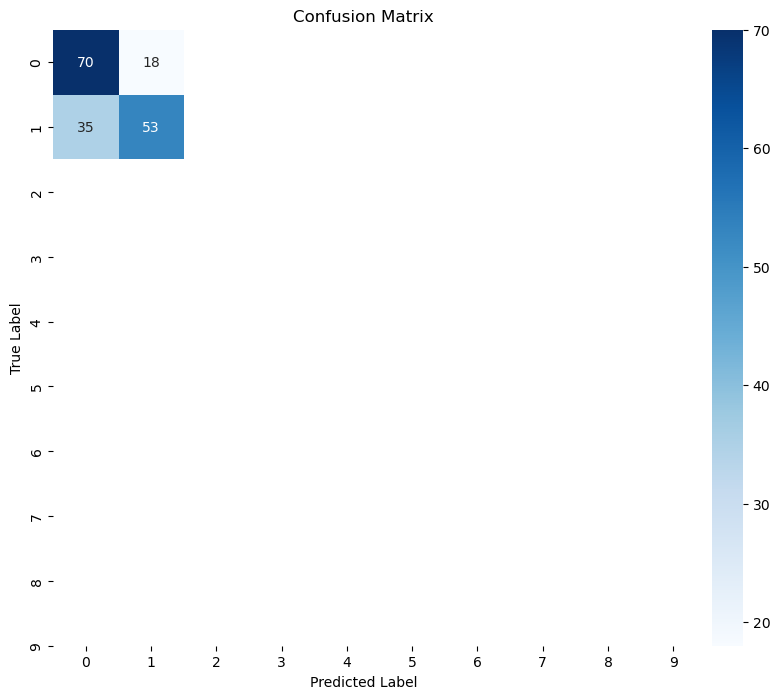

In [112]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy Score: {accuracy}')

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()